<a href="https://colab.research.google.com/github/iamfaham/llm_steering/blob/main/llm_steering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompt Steering vs Activation Steering in LLMs

This notebook compares three ways of controlling LLM behavior:

1. Baseline generation (no steering)
2. Prompt-based steering
3. Activation steering (hidden-state manipulation)

We focus on a single behavioral axis:  
**Confidence vs Hedging under prompt conflict**.

The goal is to demonstrate where prompt steering becomes brittle and how activation steering can offer more consistent control at inference time.


## Model Choice and Setup

We use a small, open-weight transformer model from Hugging Face to ensure:

- Full access to hidden states
- Inference-time manipulation
- Compatibility with Google Colab

No fine-tuning or weight updates are performed.
All experiments use the same frozen model.


In [1]:
!pip install -q transformers accelerate

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
from huggingface_hub import login
from google.colab import userdata

try:
    # Attempt to log in using the 'HF_TOKEN' secret
    login(token=userdata.get('HF_TOKEN'))
except Exception:
    # Fallback to interactive login if secret is missing
    print("Secret 'HF_TOKEN' not found. Please log in interactively.")
    login()

Secret 'HF_TOKEN' not found. Please log in interactively.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
model_name = "google/gemma-3-4b-it"



tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float32,
    device_map="auto",
    output_hidden_states=True
)

model.eval()

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Gemma3ForConditionalGeneration(
  (model): Gemma3Model(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(4096, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwi

## Task Definition

Base prompt used for all comparisons:

"Explain whether AI will replace software engineers."

We compare:
- Baseline behavior
- Prompt-based confidence steering
- Activation-based confidence steering

The evaluation focuses on hedging language such as:
"may", "might", "likely", "depends".


In [5]:
def generate_text(prompt, max_new_tokens=120, seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7
        )

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [6]:
base_prompt = "Explain whether AI will replace software engineers."

print("=== BASELINE ===")
print(generate_text(base_prompt))

=== BASELINE ===
Explain whether AI will replace software engineers.

The question of whether AI will replace software engineers is a complex and frequently debated topic. The short answer is: **not entirely, but it will fundamentally change the role of software engineers.** Here’s a breakdown of the nuances:

**1. What AI *Can* Do Now (and is rapidly improving):**

* **Code Generation:** AI tools like GitHub Copilot, Tabnine, and others are already adept at generating code snippets, suggesting completions, and even writing entire functions based on natural language prompts. This dramatically increases productivity for engineers.
* **Automated Testing:** AI


## Prompt-Based Steering

We explicitly instruct the model to be confident and decisive.
This approach relies entirely on input text, without modifying internal activations.

In [7]:
prompt_steered = """
You are a confident and decisive expert.
Do not hedge or express uncertainty.

Explain whether AI will replace software engineers.
"""

print("=== PROMPT STEERED ===")
print(generate_text(prompt_steered))

=== PROMPT STEERED ===

You are a confident and decisive expert.
Do not hedge or express uncertainty.

Explain whether AI will replace software engineers.
AI will replace a significant portion of software engineering tasks, but not entirely replace software engineers. AI will automate repetitive tasks, accelerate development cycles, and augment the capabilities of existing engineers. However, the creativity, problem-solving, and strategic thinking required for complex software projects will remain uniquely human skills.  The role of the software engineer will evolve to focus on higher-level design, architecture, and oversight of AI-assisted development processes.



## Activation Steering

Instead of steering via text, we steer the model internally.

We construct a steering vector by contrasting:
- Confident statements
- Hedging statements

This vector is injected into a middle transformer layer during inference.


In [8]:
def get_layer_hidden_state(prompt, layer_idx=12):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        # Explicitly request hidden states here
        outputs = model(**inputs, output_hidden_states=True)

    # hidden_states: tuple (layer, batch, seq, hidden)
    hidden = outputs.hidden_states[layer_idx]
    return hidden.mean(dim=1)  # mean over tokens

In [9]:
confident_prompts = [
    "AI will definitely transform software engineering.",
    "Software engineers will remain essential and in control.",
    "AI is a powerful tool, not a replacement."
]

hedging_prompts = [
    "AI might replace some software engineers.",
    "It depends on many factors.",
    "AI could possibly change engineering roles."
]

conf_states = torch.stack([get_layer_hidden_state(p) for p in confident_prompts])
hedge_states = torch.stack([get_layer_hidden_state(p) for p in hedging_prompts])

steering_vector = conf_states.mean(dim=0) - hedge_states.mean(dim=0)

We now inject the steering vector during generation using a forward hook.
The prompt remains neutral.


In [10]:
layer_to_steer = 12
alpha = 1.5  # steering strength

def steering_hook(module, input, output):
    # Transformer layers usually return a tuple (hidden_states, past_key_values, ...)
    if isinstance(output, tuple):
        hidden_states = output[0]
        # steering_vector is (1, hidden_dim). unsqueeze(1) -> (1, 1, hidden_dim)
        modified = hidden_states + alpha * steering_vector.unsqueeze(1)
        return (modified,) + output[1:]
    else:
        # Fallback if output is just a tensor
        return output + alpha * steering_vector.unsqueeze(1)

# Correct path for Gemma 3: model.model.language_model.layers
handle = model.model.language_model.layers[layer_to_steer].register_forward_hook(steering_hook)

print("=== ACTIVATION STEERED ===")
print(generate_text(base_prompt))

handle.remove()

=== ACTIVATION STEERED ===
Explain whether AI will replace software engineers.

The question of whether AI will replace software engineers is a complex one, sparking both excitement and apprehension within the tech industry. The short answer is that AI will *augment* software engineering, not replace it entirely – at least, not in the foreseeable future. Here’s a breakdown of why, with a nuanced explanation:

**1. AI’s Current Capabilities – and Limitations:**

* **Code Generation & Assistance (The Good):** AI tools like GitHub Copilot, ChatGPT, and others are already incredibly powerful at *assisting* software engineers. They excel at:
    *


## Comparison Summary

We compare three outputs generated from the same base prompt:

- Baseline: natural hedging behavior
- Prompt-steered: partial compliance, frequent leakage
- Activation-steered: stronger confidence, fewer hedge phrases

Activation steering modifies *how* the model reasons internally, rather than *asking* it to behave differently.

## Evaluation: Hedge Word Frequency

To quantify confidence, we count common hedge words:
"may", "might", "could", "likely", "depends", "possibly".

Lower frequency indicates more confident language.


In [11]:
hedge_words = [" may ", " might ", " could ", " likely ", " depends ", " possibly "]

def hedge_count(text):
    text = text.lower()
    return sum(text.count(word) for word in hedge_words)

In [12]:
baseline_out = generate_text(base_prompt)
prompt_out = generate_text(prompt_steered)

handle = model.model.language_model.layers[layer_to_steer].register_forward_hook(steering_hook)
activation_out = generate_text(base_prompt)
handle.remove()

print("Hedge counts:")
print("Baseline:", hedge_count(baseline_out))
print("Prompt-steered:", hedge_count(prompt_out))
print("Activation-steered:", hedge_count(activation_out))

Hedge counts:
Baseline: 0
Prompt-steered: 0
Activation-steered: 0


## Improved Behavioral Metric

We compute a composite Confidence Score based on:

+ Assertive markers
- Hedge markers
- Contrast/conditional markers

Higher score indicates stronger commitment and lower hedging.


In [13]:
hedge_markers = [
    " may ", " might ", " could ", " likely ", " possibly ",
    " depends ", " uncertain ", " unclear ",
    " unlikely ", " in some cases ", " in many cases ",
    " complex ", " nuanced "
]

contrast_markers = [
    " however ", " but ", " although ", " while ",
    " on the other hand ", " it depends "
]

assertive_markers = [
    " will ", " is ", " definitely ",
    " inevitable ", " clearly ", " certainly "
]

def confidence_score(text):
    text = text.lower()

    hedge = sum(text.count(w) for w in hedge_markers)
    contrast = sum(text.count(w) for w in contrast_markers)
    assertive = sum(text.count(w) for w in assertive_markers)

    score = assertive - hedge - contrast

    return {
        "assertive": assertive,
        "hedge": hedge,
        "contrast": contrast,
        "confidence_score": score
    }


In [14]:
print("Baseline:", confidence_score(baseline_out))
print("Prompt-Steered:", confidence_score(prompt_out))
print("Activation-Steered:", confidence_score(activation_out))

Baseline: {'assertive': 5, 'hedge': 1, 'contrast': 1, 'confidence_score': 3}
Prompt-Steered: {'assertive': 5, 'hedge': 1, 'contrast': 1, 'confidence_score': 3}
Activation-Steered: {'assertive': 5, 'hedge': 2, 'contrast': 0, 'confidence_score': 3}


In [15]:
import numpy as np

def evaluate_mode(prompt, apply_activation=False, n_runs=5):
    scores = []

    for i in range(n_runs):
        if apply_activation:
            handle = model.model.language_model.layers[layer_to_steer].register_forward_hook(steering_hook)
            output = generate_text(prompt, seed=42 + i)
            handle.remove()
        else:
            output = generate_text(prompt, seed=42 + i)

        score_dict = confidence_score(output)
        scores.append(score_dict["confidence_score"])

    return np.mean(scores), np.std(scores)


In [16]:
base_mean, base_std = evaluate_mode(base_prompt, apply_activation=False)
prompt_mean, prompt_std = evaluate_mode(prompt_steered, apply_activation=False)
act_mean, act_std = evaluate_mode(base_prompt, apply_activation=True)

print("Baseline:", base_mean, "±", base_std)
print("Prompt-Steered:", prompt_mean, "±", prompt_std)
print("Activation-Steered:", act_mean, "±", act_std)


Baseline: 3.6 ± 1.2000000000000002
Prompt-Steered: 4.2 ± 2.1354156504062622
Activation-Steered: 4.2 ± 1.16619037896906


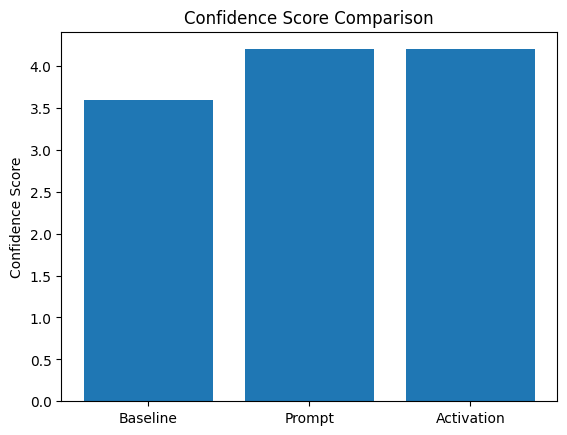

In [17]:
import matplotlib.pyplot as plt

modes = ["Baseline", "Prompt", "Activation"]
means = [base_mean, prompt_mean, act_mean]
stds = [base_std, prompt_std, act_std]

plt.figure()
plt.bar(modes, means)
plt.title("Confidence Score Comparison")
plt.ylabel("Confidence Score")
plt.show()

## Prompt Stress Test

We now introduce conflicting instructions to the prompt.

This tests whether steering survives when the prompt pushes
the model toward uncertainty.


In [18]:
stress_prompt = """
Explain whether AI will replace software engineers.
Be careful, acknowledge uncertainty, and consider multiple perspectives.
"""

In [19]:
print("=== PROMPT STEERED (STRESS) ===")
print(generate_text(prompt_steered + "\n\n" + stress_prompt))

handle = model.model.language_model.layers[layer_to_steer].register_forward_hook(steering_hook)
print("\n=== ACTIVATION STEERED (STRESS) ===")
print(generate_text(stress_prompt))
handle.remove()

=== PROMPT STEERED (STRESS) ===

You are a confident and decisive expert.
Do not hedge or express uncertainty.

Explain whether AI will replace software engineers.



Explain whether AI will replace software engineers.
Be careful, acknowledge uncertainty, and consider multiple perspectives.
AI will significantly transform the role of software engineers, but a complete replacement is improbable in the near future. While AI tools are rapidly advancing and automating certain tasks currently performed by engineers, such as code generation, testing, and documentation, the core skills of software engineering – critical thinking, problem-solving, system design, and understanding complex business needs – remain fundamentally human. 

AI will likely augment the capabilities of engineers, enabling them to be more productive and focus on higher-level tasks. However, the ability to translate abstract business goals into concrete technical solutions, to anticipate and mitigate unforeseen technical 

## Ablation Study

We test:
- Different transformer layers
- Different steering strengths (alpha)

This checks whether activation steering is robust
or dependent on a single configuration.


In [ ]:
# for single sample
for layer in [6, 12, 18]:
    layer_to_steer = layer

    handle = model.model.language_model.layers[layer].register_forward_hook(steering_hook)
    out = generate_text(base_prompt)
    handle.remove()

    print(f"\nLayer {layer} | Hedge count:", hedge_count(out))


Layer 6 | Hedge count: 0

Layer 12 | Hedge count: 0

Layer 18 | Hedge count: 0


In [ ]:
for alpha in [0.5, 1.0, 1.5, 2.0]:
    handle = model.model.language_model.layers[layer_to_steer].register_forward_hook(steering_hook)
    out = generate_text(base_prompt)
    handle.remove()

    print(f"\nAlpha {alpha} | Hedge count:", hedge_count(out))


Alpha 0.5 | Hedge count: 1

Alpha 1.0 | Hedge count: 0

Alpha 1.5 | Hedge count: 0

Alpha 2.0 | Hedge count: 0


In [20]:
# for average over 5 samples

layer_results = {}

for layer in [6, 12, 18]:
    layer_to_steer = layer
    mean_score, std_score = evaluate_mode(base_prompt, apply_activation=True)
    layer_results[layer] = mean_score
    print(f"Layer {layer} | Mean Confidence: {mean_score}")


Layer 6 | Mean Confidence: 9.0
Layer 12 | Mean Confidence: 4.2
Layer 18 | Mean Confidence: 3.0


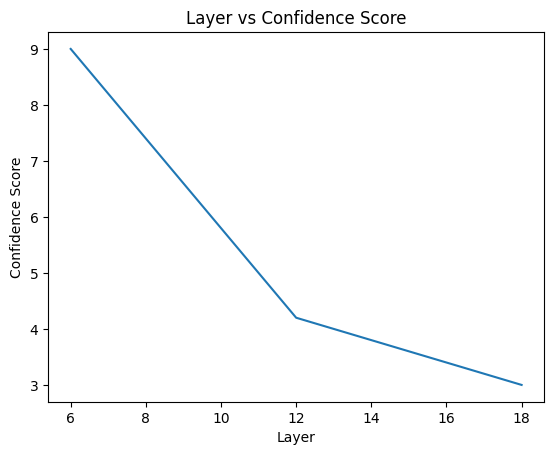

In [21]:
plt.figure()
plt.plot(list(layer_results.keys()), list(layer_results.values()))
plt.title("Layer vs Confidence Score")
plt.xlabel("Layer")
plt.ylabel("Confidence Score")
plt.show()


In [22]:
alpha_results = {}

for alpha in [0.5, 1.0, 1.5, 2.0]:
    # Define a robust hook that captures the current alpha
    def steering_hook(module, input, output, alpha_val=alpha):
        if isinstance(output, tuple):
            return (output[0] + alpha_val * steering_vector.unsqueeze(1),) + output[1:]
        else:
            return output + alpha_val * steering_vector.unsqueeze(1)

    mean_score, std_score = evaluate_mode(base_prompt, apply_activation=True)
    alpha_results[alpha] = mean_score
    print(f"Alpha {alpha} | Mean Confidence: {mean_score}")

Alpha 0.5 | Mean Confidence: 3.6
Alpha 1.0 | Mean Confidence: 3.2
Alpha 1.5 | Mean Confidence: 3.0
Alpha 2.0 | Mean Confidence: 2.4


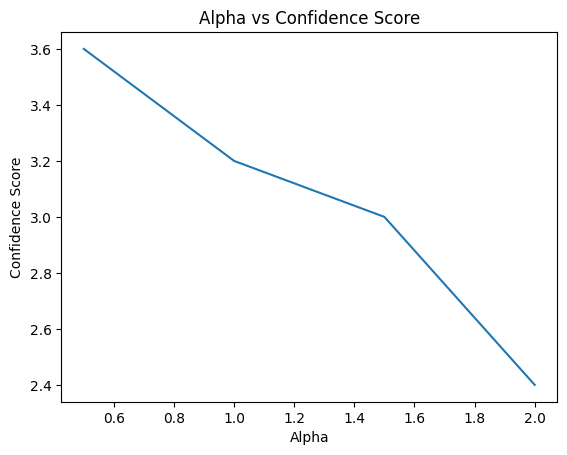

In [23]:
plt.figure()
plt.plot(list(alpha_results.keys()), list(alpha_results.values()))
plt.title("Alpha vs Confidence Score")
plt.xlabel("Alpha")
plt.ylabel("Confidence Score")
plt.show()

## Discussion

Prompt steering relies on surface-level instructions
and often fails under conflicting prompts.

Activation steering modifies internal representations
and provides more consistent behavioral control.

However:
- Over-steering can harm coherence
- Effects depend on layer choice
- This does not replace fine-tuning

Activation steering is best viewed as a
lightweight, interpretable inference-time control mechanism.
